# ELG5218 - Time Series Model

 Juntong Xiao #300139518

**Navigation:**

[Model Overview](#1)

[Julia implementation of the change point, outlier detection, time series forecasting model](#2)

[ARIMA Model](#3)

In [1]:
using Random
using LinearAlgebra
using Distributions
using StatisticalRethinking

In [2]:
using Turing, StatsBase
using MCMCChains, Plots, StatsPlots

In [3]:
using HypothesisTests

# <a id="1"></a>Model Overview 
In this model, the time series sequence is composed by trend, change points, and anomaly outliers. At each time point, a observation can either be a normal data point or a outlier, so the **observation** at time $t$ can be expressed as:
    \begin{equation}
        y_t=\mu_t+
        \begin{cases}
            \epsilon_t&\text{if } z^a_t=0\\
            o_t&\text{if } z^a_t=1
        \end{cases}
        \tag{1}
    \end{equation}
    
* The outlier component in this model is represented by a binary sequence $\pmb{z^a}$, with the $z^a_t=1$ represents this point is a outlier.

The **mean** of the observation $\mu$ of this model can be expressed as:
    \begin{align*}
        &\mu_t=\mu_{t-1}+\delta_{t-1}+
        \begin{cases}
            u_t&\text{if } z^c_t=0\\
            r_t&\text{if } z^c_t=1
        \end{cases}\\
        &\delta_t=\delta_{t-1}+v_t
    \end{align*}
In this linear Gaussian model, $\mu$ can represent the trend of the time series. And the equations above can determine the transition of a state at time $t$ to a new state at time $t+1$.
    
* Similar to the outlier component, the change points are represented by sequence $\pmb{z^c}$.
* The change of the trend at one time point is modeled by $\pmb{\delta}$.



All the **noises** in this model are normally distributed as:
$$\epsilon_t\sim\mathcal{N}(0,\sigma_\epsilon^2)\quad o_t\sim\mathcal{N}(0,\sigma_o^2)$$
$$u_t\sim\mathcal{N}(0,\sigma_u^2)\quad r_t\sim\mathcal{N}(0,\sigma_r^2)\quad v_t\sim\mathcal{N}(0,\sigma_v^2)$$
        
**Change points and outlier indicators** follow the Bernoulli distribution as:
$$z^a_t\sim{\rm Bernoulli}(p_a)\quad z^c_t\sim {\rm Bernoulli}(p_c)$$

So now, we can derive the likelihood of this model as followings:
    \begin{cases}
            z^a_t=0,&y_t\sim\mathcal{N}(\mu,\sigma^2_\epsilon)\\
            z^a_t=1,&y_t\sim\mathcal{N}(\mu,\sigma^2_o)
    \end{cases}
    \begin{cases}
            z^c_t=0,&\mu_t\sim\mathcal{N}(\mu_{t-1}+\delta_{t-1},\sigma^2_u)\\
            z^c_t=1,&\mu_t\sim\mathcal{N}(\mu_{t-1}+\delta_{t-1},\sigma^2_r)
    \end{cases}

# <a id="2"></a>Julia implementation of the change point, outlier detection, time series forecasting model
## Algorithm
### 1. Inferring $\pmb{\alpha}$
#### a. State Space Model
State space model can be used to describe the relationship between the latent state variable and the measurement.

From the previous equations, here we can build the state space model as:
    \begin{equation}
        \alpha_t=\pmb{T}_{t-1}\alpha_{t-1}+R_{t-1}C_{t-1}\pmb{\eta}_{t-1}+R_{t-1}(1-C_{t-1})\pmb{\xi}_{t-1}
    \end{equation}
    \begin{equation}
        y_t=\pmb{Z}_t\pmb{\alpha}_t+A_to_t+(1-A_t)\epsilon_t
    \end{equation}
    
So, we can obtain the measurement at time $t$ by using:
    $$\pmb{\alpha}_t\sim p(\pmb{\alpha}_t|\pmb{\alpha}_{t-1})$$
    $$y_t\sim p(y_t|\pmb{\alpha}_{t})$$

We can represent this model by:
<img src="model.png" width="400" height="200"/>
    
In the state space model, we have $\pmb{T}$ represents the transition matrix, and $\pmb{Z}$ represents the emission matrix, and set them to:
$$\pmb{T}=\begin{bmatrix}1&1\\0&1\end{bmatrix}\quad\pmb{Z}=(1,0)$$
And the process and measurement noises are modeled as:
$$\pmb{\eta}_t\sim\mathcal{N}(0,\pmb{Q}^\eta_t)\quad\pmb{\xi}_t\sim\mathcal{N}(0,\pmb{Q}^\xi_t)$$
$$o_t\sim\mathcal{N}(0,H^o_t)\quad\epsilon\sim\mathcal{N}(0,H^\epsilon_t)$$
Here we have:
$$\pmb{Q}^\eta=\begin{bmatrix}\sigma^2_r&0\\0&\sigma^2_v\end{bmatrix}\quad \pmb{Q}^\xi=\begin{bmatrix}\sigma^2_u&0\\0&\sigma^2_v\end{bmatrix}\quad H^o=\sigma^2_o\quad H^\epsilon=\sigma^2_\epsilon$$

#### b. State Variable $\pmb{\alpha}$
State variable is used to describe the mathematical state of a dynamical system at time $t$. The obtained the state variable can be used to determine the future behaviour of the system. Thus, we can use it to predict future outputs.

In this model, we set the state variable $\pmb{\alpha}$ as $\pmb{\alpha}_t=\begin{bmatrix} \mu_t \\ \delta_t\end{bmatrix}$. And we set $\pmb{R}=\begin{bmatrix}1&0\\0&1\end{bmatrix}$.

So, here we can derive the $\pmb{\alpha}_t$ as:
    \begin{equation}
        \pmb{\alpha}_t=T_{t-1}\alpha_{t-1}+C_{t-1}\begin{bmatrix}r_{t-1}\\v_{t-1}\end{bmatrix}+(1-C_{t-1})\begin{bmatrix}u_{t-1}\\v_{t-1}\end{bmatrix}
    \end{equation}

For the beginning of the Kalman Filter, we initialize it with $\pmb{\alpha}_1 \sim \mathcal{N}(\pmb{a}_1,\pmb{P}_1)$, which are:
$$\pmb{a}_1=\begin{bmatrix}y_1\\0\end{bmatrix}\quad \pmb{P}_1=\begin{bmatrix}d&0\\0&d\end{bmatrix}$$

#### c. Kalman Filter
Instead of estimating the state of a system based on one single observation, Kalman filter uses the measurements which are observed over time. By using Kalman filter, the real state of the system can be better predicted, and the influences caused by noises can be reduced. Kalman filter defines an optimal algorithm for inferring the linear Gaussian models.

The Kalman filter has long been regarded as the optimal solution for data prediction with linear Gaussian model.

The recursion of the Kalman filter for the state space model above can be described as:

1.Obtain the predicted mean and variance.
            \begin{align*}
                \pmb{a}_{t|t-1} &= \pmb{T}\pmb{a}_{t-1}\\
                \pmb{P}_{t|t-1} &= \pmb{T}\pmb{P}_{t-1}\pmb{T}^T+R[p^c_{t-1}\pmb{Q}^\eta+(1-p^c_{t-1})\pmb{Q}^\xi]R^T
            \end{align*}

$\pmb{a}_{t|t-1}$ and $\pmb{P}_{t|t-1}$ are actually the prior state estimate.

2.Compute the Kalman Gain
            \begin{align*}
                F_t &= \pmb{Z}\pmb{P}_{t|t-1}\pmb{Z}^T+p^a_tH^o+(1-p^a_t)H^\epsilon\\
                \pmb{K}_t &= F_t^{-1}\pmb{T}\pmb{P}_{t|t-1}\pmb{Z}^T
            \end{align*}
            
Kalma gain can determine the proportion of the uncertainty in estimate and the uncertainty in measurement and estimation. To be more specific, if K=0, the state will depend on predicted values, but if K=1, the state will depend on the measured values.          
            
3.Update with the estimated mean and variance
            \begin{align*}
                v_t &= y_t-\pmb{Z}\pmb{a}_{t-1}\\
                \pmb{a}_t &= \pmb{a}_{t|t-1}+\pmb{K}_tv_t\\
                \pmb{P}_t &= \pmb{P}_{t|t-1}-\pmb{P}_{t|t-1}\pmb{Z}F^{-1}\pmb{Z}\pmb{P}_{t|t-1}
            \end{align*}  

$\pmb{a}_t$ and $\pmb{P}_t$ are the posterior state estimate.

Now, we have the complete loop of the Kalman filter. After iterating all $y_t$ from the sequence, we can obtain $\{\pmb{\alpha}_t|y_{1:L_{train}}\}_{t=1:L_{train}}$

#### <a name="gen_a_1"></a> Functions for the Kalman Filter

In [11]:
function gen_a_1(y)
    # a_1=(mu_1,delta_1)
    # mu_1 is initialized with y_1
    # delta_1 = 0
    a_1=zeros(2,1)
    a_1[1]=y[1]
    return a_1
end

function gen_P_1(d)
    # d = Var(a_t|Y_(t-1))
    return d*Matrix{Float64}(I, 2, 2)
end

function gen_Z_t()
    Z_mu=[1,0]
    Z_mu=reshape(Z_mu,1,2)
    return Z_mu
end

function gen_T_t()
    T_mu=ones(2,2)
    T_mu[2,1]=0
    return T_mu
end

function gen_R_t()
    return Matrix{Float64}(I, 2, 2)
end

function gen_Q_eta(sigma_r, sigma_v)
    return Diagonal([sigma_r^2, sigma_v^2])
end

function gen_Q_xi(sigma_u, sigma_v)
    return Diagonal([sigma_u^2, sigma_v^2])
end

gen_Q_xi (generic function with 1 method)

In [88]:
function kalman_filter_using_p(L, y, a_1, P_1, Z_t, p_a_list, p_c_list, T_t, H_e, H_o, Q_eta, Q_xi, R_t)
    # The recursion of this function is slightly different from the above recursion.
    #So, the order of "Preidction" and "Estimation" is the opposite of the original recursion.
    #But in overall terms, the estimated means will be saved to the output vector a.
    a_t = a_1
    P_t = P_1
    
    a=Array[a_t]
    P=Array[P_t]
    K = Array[]
    v = zeros(0)
    F = zeros(0)
    
    for t in 1:L-1
        p_a = p_a_list[t]
        p_c = p_c_list[t]
        
        F_t = (Z_t * P_t * (Z_t'))[1] + p_a*H_o + (1-p_a)*H_e
        K_t = (1/F_t)*(T_t * P_t * (Z_t')) # Kalman gain
        v_t = y[t] - (Z_t * a_t)[1]
        
        # Estimation
        P_tt = P_t - (1/F_t)*(P_t * (Z_t') * Z_t * P_t) 
        a_t_new = T_t * a_t + v_t*K_t
        
        # Prediction
        P_t_new = T_t * P_tt * (T_t') + R_t * (p_c*Q_eta + (1-p_c)*Q_xi) * (R_t') 
        
        a_t = a_t_new
        P_t = P_t_new
        push!(a,a_t)
        append!(v,v_t)
        append!(F,F_t)
        push!(K,K_t)
        push!(P,P_t)
    end
    
    p_a = p_a_list[L]
    p_c = p_c_list[L]
    v_t = y[L] - (Z_t * a[L])[1]
    append!(v,v_t)
    F_t = (Z_t * P[L] * (Z_t'))[1] + p_a*H_o + (1-p_a)*H_e
    append!(F,F_t)
    K_t = (1/F[L])*T_t * P[L] * (Z_t')
    push!(K,K_t)

    return a, P, K, F, v
end

kalman_filter_using_p (generic function with 1 method)

### 2. Updating Change Point and Outlier Indicator sequence $\pmb{z}$
#### Change Point and Outlier Detection
According to the distributions of $y_t$ and $\mu_t$, we can update the $\pmb{p}=(\pmb{p_a},\pmb{p_c})$ by:
$$p^a_t=\frac{\frac{p_a}{\sigma_o}exp[-\frac{(y_t-\mu_t)^2}{2\sigma^2_o}]}{\frac{1-p_a}{\sigma_\epsilon}exp[-\frac{(y_t-\mu_t)^2}{2\sigma^2_\epsilon}]+\frac{p_a}{\sigma_o}exp[-\frac{(y_t-\mu_t)^2}{2\sigma^2_o}]}$$
$$p^c_t=\frac{\frac{p_c}{\sigma_r}exp[-\frac{(\mu_t-\mu_{t-1}-\delta_{t-1})^2}{2\sigma^2_r}]}{\frac{1-p_a}{\sigma_u}exp[-\frac{(\mu_t-\mu_{t-1}-\delta_{t-1})^2}{2\sigma^2_u}]+\frac{p_a}{\sigma_r}exp[-\frac{(\mu_t-\mu_{t-1}-\delta_{t-1})^2}{2\sigma^2_r}]}$$

And then we can obtain a new $\pmb{z}=(\pmb{z}^a, \pmb{z}^c)$ from updated $\pmb{p}$ by: 
    $$z_t^a\sim{\rm Bernoulli}(p^a_t)$$
    $$z_t^c\sim{\rm Bernoulli}(p^c_t)$$

It is worth to mention that in this model, the $\pmb{p}$ actually will not be updated after obtaining the new $\pmb{z}$. It is because of in the early iterations, $\pmb{z}$ could stuck at 0. By doing this, the robustness of this model will be improved.

In [13]:
function update_p_a_t(p_a, sigma_o, sigma_e, y_t, mu_t)
    distr_1 = Normal(mu_t,sigma_o)
    distr_0 = Normal(mu_t,sigma_e)
    p_a_t_1 = p_a * exp(logpdf(distr_1,y_t))
    p_a_t_0 = (1 - p_a) * exp(logpdf(distr_0,y_t)) 
    return (p_a_t_1 / (p_a_t_1 + p_a_t_0))
end
    
function update_p_c_t(p_c, sigma_r, sigma_u, mu_t, mu_t_prev, delta_t_prev)
    distr_1 = Normal(mu_t_prev + delta_t_prev,sigma_r)
    distr_0 = Normal(mu_t_prev + delta_t_prev,sigma_u)
    p_c_t_1 = p_c * exp(logpdf(distr_1,mu_t))
    p_c_t_0 = (1 - p_c) * exp(logpdf(distr_0,mu_t))
    return (p_c_t_1 / (p_c_t_1 + p_c_t_0))
end


function generate_z_a_t(p_a, sigma_o, sigma_e, y_t, mu_t)
    p_a_t = update_p_a_t(p_a, sigma_o, sigma_e, y_t, mu_t)
    return rand(Bernoulli(p_a_t),1)[1]
end
    
function generate_z_c_t(p_c, sigma_r, sigma_u, mu_t, mu_t_prev, delta_t_prev)
    p_c_t = update_p_c_t(p_c, sigma_r, sigma_u, mu_t, mu_t_prev, delta_t_prev)
    return rand(Bernoulli(p_c_t),1)[1]
end

generate_z_c_t (generic function with 1 method)

### 3. Updating parameters $\pmb{\sigma}$
After inferring $\pmb{\alpha}$ and updating $\pmb{z}$, the $\pmb{\sigma}=(\sigma_\epsilon, \sigma_o, \sigma_u, \sigma_r, \sigma_v)$ can be updated by computing the empirical standard deviations as follows:
    $$\sigma_\epsilon=\sqrt{\sum_{t:z^a_t=0}\frac{(y_t-\mu_t)^2}{n_{z^a_t=0}}}\quad \sqrt{\sigma_o=\sum_{t:z^a_t=1}\frac{(y_t-\mu_t)^2}{n_{z^a_t=1}}}$$
    $$\sigma_u=\sqrt{\sum_{t:z^c_t=0}\frac{(\mu_t-\mu_{t-1}-\delta_{t-1})^2}{n_{z^c_t=0}}}\quad \sigma_r=\sqrt{\sum_{t:z^c_t=1}\frac{(\mu_t-\mu_{t-1}-\delta_{t-1})^2}{n_{z^c_t=1}}}$$
    $$\sigma_v=\sqrt{\frac{\sum^n_{t=1}(\delta_t-\delta_{t-1})^2}{n}}$$

In [14]:
function update_sigma_e(y, mu, z_a, sigma_e)
    if sum(findall(z_a .== 0)) == 0
        return sigma_e 
    end
    t_not_anomaly = findall(z_a .== 0)
    n = length(t_not_anomaly)
    y_not_a = y[t_not_anomaly]
    mu_not_a = mu[t_not_anomaly]
    sigma_e = ( sum((y_not_a .- mu_not_a).^2) / n)^ 0.5
    return sigma_e
end

function update_sigma_o(y, mu, z_a, sigma_o)
    if sum(findall(z_a .!= 0)) == 0
        return sigma_o
    end
    t_anomaly = findall(z_a .!= 0)
    n = length(t_anomaly)    
    y_a = y[t_anomaly]
    mu_a = mu[t_anomaly]   
    sigma_o = ( sum((y_a .- mu_a).^2) / n)^ 0.5    
    return sigma_o
end


function update_sigma_u(mu,mu_with_initial_values, delta, delta_with_initial_values, z_c, sigma_u)
    if sum(findall(z_c .== 0)) == 0
        return sigma_u
    end
    t_not_change = findall(z_c .== 0)
    n = length(t_not_change)
    mu_not_c = mu[t_not_change]
    mu_prev_not_c = mu_with_initial_values[t_not_change]
    delta_prev_not_c = delta_with_initial_values[t_not_change]
    sigma_u = ( sum((mu_not_c .- mu_prev_not_c .- delta_prev_not_c).^2)/ (n))^ 0.5 
    return sigma_u
end
    
function update_sigma_r(mu,mu_with_initial_values, delta, delta_with_initial_values, z_c, sigma_r)
    if sum(findall(z_c .!= 0)) == 0
        return sigma_r 
    end
    t_change = findall(z_c .!= 0)
    n = length(t_change)
    mu_c = mu[t_change]
    mu_prev_c = mu_with_initial_values[t_change]
    delta_prev_c = delta_with_initial_values[t_change]
    sigma_r = ( sum((mu_c .- mu_prev_c .- delta_prev_c).^2) / (n))^ 0.5 
    return sigma_r
end
    
function update_sigma_delta(delta, delta_with_initial_values)
    n = length(delta)
    sigma_delta = (sum((delta .- delta_with_initial_values[1:end-1]).^2) / (n)) ^ 0.5
    return sigma_delta
end

update_sigma_delta (generic function with 1 method)

### 4. Calculate the Log-likelihood
The log-likelihood is calculated based on the joint distribution $p(\pmb{y,z,\alpha})$. So we can derive it as:
\begin{multline*}
            \mathcal{L}=\prod_{t:z^a_t=0}\mathcal{N}(y_t-\mu_t,\sigma_\epsilon)*\prod_{t:z^a_t=1}\mathcal{N}(y_t-\mu_t,\sigma_o)\\
            *\prod_{t:z^c_t=0}\mathcal{N}(\mu_t-\mu_{t-1}-\delta_{t-1},\sigma_u)*\prod_{t:z^c_t=1}\mathcal{N}(\mu_t-\mu_{t-1}-\delta_{t-1},\sigma_r)*\prod^n_{t=1}\mathcal{N}(\delta_t-\delta_{t-1})\\
            *\prod^n_{t=1}(p_a)^{z^a_t}(1-p_a)^{1-z^a_t}*\prod^n_{t=1}(p_c)^{z^c_t}(1-p_c)^{1-z^c_t}
        \end{multline*}
        
If the log-likelihood has not converged yet, then repeat steps from inferring the $\pmb{\alpha}$. The essential point of this algorithm is to keep updating the parameters until the log-likelihood converges.

In [15]:
function log_g(x1,x2)
    dist = [Normal(m,x2) for m in x1]
    return [logpdf(d,0) for d in dist]
end

function log_likelihood(y,mu, mu_with_initial_values, delta, delta_with_initial_values, z_a, z_c, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, p_a, p_c)
    t_not_anomaly = findall(z_a .== 0)
    if all(z_a .== 0)
        t_anomaly = []
    else
        t_anomaly = findall(z_a .!= 0) 
    end
    y_not_a = y[t_not_anomaly]
    y_a = y[t_anomaly]
    mu_not_a = mu[t_not_anomaly]
    mu_a = mu[t_anomaly]
    
    t_not_change = findall(z_c .== 0)
    if all(z_c .== 0)
        t_change = []  
    else
        t_change = findall(z_c .!= 0)
    end
    mu_not_c = mu[t_not_change]
    mu_c = mu[t_change]
    mu_prev_not_c = mu_with_initial_values[t_not_change]
    mu_prev_c = mu_with_initial_values[t_change]
    delta_prev_not_c = delta_with_initial_values[t_not_change]
    delta_prev_c = delta_with_initial_values[t_change]
    delta_prev = delta_with_initial_values[1:end-1]  
    
    n_a = sum(z_a)
    n_not_a = sum(z_a .== 0)
    n_c = sum(z_c)
    n_not_c = sum(z_c .== 0)
    
    log_L =  sum(log_g(y_not_a .- mu_not_a, sigma_e))
    
    if length(t_anomaly) > 0
        log_L = log_L + sum(log_g(y_a .- mu_a, sigma_o))
    end
    
    log_L = log_L + sum(log_g(mu_not_c .- mu_prev_not_c .- delta_prev_not_c, sigma_u))

    if length(t_change) > 0
        log_L = log_L + sum(log_g(mu_c .- mu_prev_c .- delta_prev_c, sigma_r))
    end
    
    log_L = log_L + sum(log_g(delta .- delta_prev, sigma_v))
    log_L = log_L+ n_a*(log(p_a)) + n_not_a*(log(1-p_a)) + n_c*(log(p_c)) + n_not_c*(log(1-p_c))
    
    return log_L
end

log_likelihood (generic function with 1 method)

## Data Generation

#### According to the equation (1),(2),(3), the following function can be used to  generate a time series sequence.

In [4]:
function generative_procedure_with_evaluation_period(mu_0, delta_0, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, p_a::Float64, p_c::Float64, L, L_train, t_c_fixed, c_fixed, t_r_fixed, r_fixed)
    # 1. Generate anomalies and change points indexes
    z_a = rand(Bernoulli(p_a),L)
    z_c = rand(Bernoulli(p_c),L)
    
    # 1.1 Evaluation period
    z_a[L_train+1:end] .= 0
    z_c[L_train+1:end] .= 0
    
    z_c[t_c_fixed] = c_fixed
    
    # 2. Generate noises 
    e = rand(Normal(0.,sigma_e),L)
    o = rand(Normal(0.,sigma_o),L)
    u = rand(Normal(0.,sigma_u),L)
    r = rand(Normal(0.,sigma_r),L)
    v = rand(Normal(0.,sigma_v),L)

    r[t_r_fixed] = r_fixed
    
    # 3. Generate alpha
    mu = zeros(0)
    mu_with_initial_values = [mu_0]
    delta = zeros(0)
    delta_with_initial_values = [delta_0]
    
    for t in 1:L
        mu_t = mu_with_initial_values[end] + delta_with_initial_values[end]
        delta_t = delta_with_initial_values[end] + v[t]
        if z_c[t] == 0
            mu_t = mu_t + u[t]
        else
            mu_t = mu_t + r[t]
        end
        
        append!(mu,mu_t)
        append!(mu_with_initial_values,mu_t)
        
        append!(delta,delta_t)
        append!(delta_with_initial_values,delta_t)
    end
    
    # 4. Generate y
    y = zeros(0)
    
    for t in 1:L
        y_t = mu[t] 
        if z_a[t] == 0
            y_t = y_t + e[t]
        else
            y_t = y_t + o[t]
        end     
        append!(y,y_t)
    end
        
    return y, mu, delta, mu_with_initial_values, delta_with_initial_values, z_a, z_c
end

generative_procedure_with_evaluation_period (generic function with 1 method)

#### <a name="future"></a>Function for generating without change points and outliers (this function is going to be used for forecasting):

In [5]:
function generative_procedure_future(mu_0, delta_0, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, L)
    e = rand(Normal(0.,sigma_e),L)
    o = rand(Normal(0.,sigma_o),L)
    u = rand(Normal(0.,sigma_u),L)
    r = rand(Normal(0.,sigma_r),L)
    v = rand(Normal(0.,sigma_v),L)
    
    mu = zeros(0)
    mu_with_initial_values = [mu_0]
    delta = zeros(0)
    delta_with_initial_values = [delta_0]
    
    for t in 1:L
        mu_t = mu_with_initial_values[end] + delta_with_initial_values[end]
        delta_t = delta_with_initial_values[end] + v[t]
      
        mu_t = mu_t + u[t]
        
        append!(mu,mu_t)
        append!(mu_with_initial_values,mu_t)
        
        append!(delta,delta_t)
        append!(delta_with_initial_values,delta_t)
    end
    
    # 4. Generate y
    y = zeros(0)
    for t in 1:L
        y_t = mu[t]
        y_t = y_t + e[t]
        append!(y,y_t)
    end
    
    return y
end

generative_procedure_future (generic function with 1 method)

In [135]:
function plot_time_series(L,y, z_a, z_c)
    p=plot(1:L,y,label=false,size=(900,400))
    
    nonzero_z_a=findall(z_a .!= 0)
    nonzero_z_c=findall(z_c .!= 0)
    scatter!(nonzero_z_a,y[nonzero_z_a],label=false)
    for c in nonzero_z_c
        vline!([c],linestyle=:dash,color=:blue,label=false)   
    end
    return p
end

plot_time_series (generic function with 2 methods)

#### Generating A Dataset
Here we choose $\mu_0 = 20.0, \delta_0 = 0.0$ as the initial trend $\tilde{\pmb{a}}_1$, and generate a sequence $\tilde{\pmb{y}}$.

In [86]:
L = 500
L_train = 350

sigma_e = 0.1
sigma_o = 4.
sigma_u = 0.1
sigma_r = 1.
sigma_v = 0.0004

# alpha_1
mu_0 = 20.
delta_0 = 0.

p_c = 4 / 350
p_a = 10 / 350

t_c_fixed = 330
c_fixed = 1.
t_r_fixed = 330
r_fixed = 2.

y, mu, delta, mu_with_initial_values, delta_with_initial_values, z_a, z_c = generative_procedure_with_evaluation_period(mu_0, delta_0, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, p_a, p_c, L, L_train, t_c_fixed, c_fixed, t_r_fixed, r_fixed)

([19.99195301895324, 20.32238508946672, 20.919591096583403, 20.915660853974853, 20.9137964701604, 20.637308190740416, 20.65707504988161, 20.77315241266452, 21.062141624285076, 21.447415619650684  …  23.591713636252436, 23.677667341370825, 23.401300858258278, 23.59280328344223, 23.48576578518277, 23.474414557648693, 23.684437307606682, 23.361982304283867, 23.785176939893994, 23.651581757759363], [20.021245363079192, 20.242351942858342, 20.885900792342298, 20.827388554514116, 20.934097236349295, 20.75245114010549, 20.762594220743676, 20.567604070030466, 21.17814816514764, 21.263743450704936  …  23.622828821107117, 23.53685922161827, 23.482987970152134, 23.588441322492834, 23.557803522950216, 23.531366859273643, 23.55043953599188, 23.504643899823265, 23.611455222803812, 23.650505977341997], [0.0004803730311170647, 0.00015901269532391768, 5.130487667287943e-5, 0.0003408432687161894, 0.0007731406142467586, 0.000741510204018919, 0.0003798844326932529, 0.00010457773778525472, 0.00044660901954

In [89]:
#### Save the generated data ####
mu_true = mu
delta_true = delta
z_a_true = z_a
z_c_true = z_c
sigma_true = [sigma_e, sigma_o, sigma_u, sigma_r, sigma_v]

p_a_true = p_a
p_c_true = p_c

a_1_true = [mu_0,delta_0]
a_1_true = reshape(a_1_true,2,1)

2×1 Array{Float64,2}:
 20.0
  0.0

#### The visualized result is showed as follow:
The change points are marked with dashed lines, and the outliers are marked by red dot.

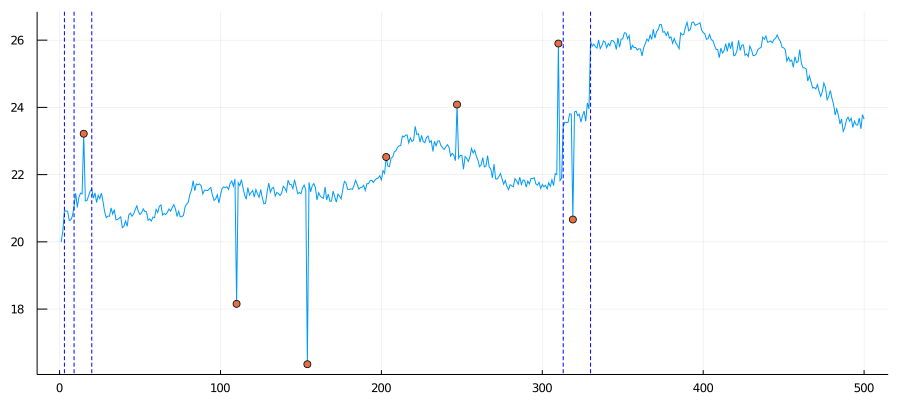

In [137]:
plot_time_series(L, y, z_a_true, z_c_true)

## Model Implementation
### 1. Initialization

#### Initialize sigma

In [90]:
# L_train=350
y_train = y[1:L_train]

y_mean = mean(y_train) #sample mean
sigma_sqr = sum((y_train .- y_mean).^2) / (L_train - 1) #sample variance
sigma = sqrt(sigma_sqr) #sample standard deviation

sigma_e = sigma_u = sigma_r = sigma
sigma_v = 0.0001
sigma_o = 4

sigma_evolution = Array[]
push!(sigma_evolution, [sigma_e, sigma_o, sigma_u, sigma_r, sigma_v])

1-element Array{Array,1}:
 [1.31782744845216, 4.0, 1.31782744845216, 1.31782744845216, 0.0001]

#### Initialize $\pmb{a}_1$
Initialize $\pmb{a}_1$ by function [gen_a_1](#gen_a_1).

In [91]:
a_1_evolution = Array[]
a_1 = gen_a_1(y_train)

2×1 Array{Float64,2}:
 19.99195301895324
  0.0

#### initialize p and z

In [92]:
p_a = p_c = 1 / L_train

z_a = rand(Bernoulli(p_a),L_train)
z_c = rand(Bernoulli(p_c),L_train)

z_a_evolution = Array[]
z_c_evolution = Array[]
p_a_evolution = Array[]
p_c_evolution = Array[]
push!(p_a_evolution,p_a * ones(L_train))
push!(p_c_evolution,p_c * ones(L_train))
push!(z_a_evolution,z_a)
push!(z_c_evolution,z_c)

print("p_a and p_c are: ", p_a, ", ", p_c)

p_a and p_c are: 0.002857142857142857, 0.002857142857142857

### 2. Inference
Here, we keep updating the parameters until the log-likelihood is converged.

In [93]:
log_L_list = []
log_L_best = - 5 * 10^6

alpha_best = []
z_c_best = []
z_a_best = []

y_best = []

Any[]

In [94]:
for epoch in 1:100
    print("!!!",epoch,"!!!")
    
    # Inferring the state variables
    d = 1000.
    P_1 = gen_P_1(d)
    Z_t = gen_Z_t()
    T_t = gen_T_t()
    R_t = gen_R_t()

    H_e = sigma_e ^ 2
    H_o = sigma_o ^ 2

    Q_eta = gen_Q_eta(sigma_r, sigma_v)
    Q_xi = gen_Q_eta(sigma_u, sigma_v)

    p_a_list = p_a_evolution[end]
    p_c_list = p_c_evolution[end]

    alpha_result, P_t, K_t, F_t, v_t = kalman_filter_using_p(L_train, y_train, a_1, P_1, Z_t, p_a_list, p_c_list, T_t, H_e, H_o, Q_eta, Q_xi, R_t)
    a_1 = alpha_result[1]
    push!(a_1_evolution,a_1)
    y_result = [a[1] + a[2] for a in alpha_result]

    # Updating z
    z_a = [0.]
    z_c = [0.]
    p_a_new = [0.]
    p_c_new = [0.]

    for t in 2:L_train
        mu_t= alpha_result[t][1]
        y_t = y_train[t]

        mu_t_prev = alpha_result[t-1][1]
        delta_t_prev = alpha_result[t-1][2]

        p_a_t = update_p_a_t(p_a, sigma_o, sigma_e, y_t, mu_t)
        p_c_t = update_p_c_t(p_c, sigma_r, sigma_u, mu_t, mu_t_prev, delta_t_prev)

        append!(z_a,generate_z_a_t(p_a, sigma_o, sigma_e, y_t, mu_t))
        append!(z_c,generate_z_c_t(p_c, sigma_r, sigma_u, mu_t, mu_t_prev, delta_t_prev))
        append!(p_a_new,p_a_t)
        append!(p_c_new,p_c_t)
    end

    z_c[end] = 0.
    push!(p_a_evolution,p_a_new)
    push!(p_c_evolution,p_c_new)
    push!(z_a_evolution,z_a)
    push!(z_c_evolution,z_c)

    # Updating sigma
    mu = [a[1] for a in alpha_result]
    delta  = [a[2] for a in alpha_result]

    delta_with_initial_values = vcat(alpha_result[1][2],delta)
    mu_with_initial_values = vcat(alpha_result[1][1] - alpha_result[1][2],mu)

    sigma_e = update_sigma_e(y_train, mu, z_a, sigma_e)
    sigma_o = update_sigma_o(y_train, mu, z_a, sigma_o) 
    sigma_u = update_sigma_u(mu,mu_with_initial_values, delta, delta_with_initial_values, z_c, sigma_u)
    sigma_r = update_sigma_r(mu,mu_with_initial_values, delta, delta_with_initial_values, z_c, sigma_r)
    sigma_delta = update_sigma_delta(delta, delta_with_initial_values)
    sigma_v = sigma_delta

    push!(sigma_evolution, [sigma_e,sigma_o,sigma_u,sigma_r,sigma_v])

    # Calculating likelihood
    log_L = log_likelihood(y_train,mu, mu_with_initial_values, delta, delta_with_initial_values, z_a, z_c, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, p_a, p_c)

    append!(log_L_list,log_L)

             # log_L_best = - 5 * 10^6
    if log_L > log_L_best
        log_L_best = log_L
        alpha_best = alpha_result

        z_c_best = z_c
        z_a_best = z_a
        
        y_best = y_result
    end
end

!!!1!!!!!!2!!!!!!3!!!!!!4!!!!!!5!!!!!!6!!!!!!7!!!!!!8!!!!!!9!!!!!!10!!!!!!11!!!!!!12!!!!!!13!!!!!!14!!!!!!15!!!!!!16!!!!!!17!!!!!!18!!!!!!19!!!!!!20!!!!!!21!!!!!!22!!!!!!23!!!!!!24!!!!!!25!!!!!!26!!!!!!27!!!!!!28!!!!!!29!!!!!!30!!!!!!31!!!!!!32!!!!!!33!!!!!!34!!!!!!35!!!!!!36!!!!!!37!!!!!!38!!!!!!39!!!!!!40!!!!!!41!!!!!!42!!!!!!43!!!!!!44!!!!!!45!!!!!!46!!!!!!47!!!!!!48!!!!!!49!!!!!!50!!!!!!51!!!!!!52!!!!!!53!!!!!!54!!!!!!55!!!!!!56!!!!!!57!!!!!!58!!!!!!59!!!!!!60!!!!!!61!!!!!!62!!!!!!63!!!!!!64!!!!!!65!!!!!!66!!!!!!67!!!!!!68!!!!!!69!!!!!!70!!!!!!71!!!!!!72!!!!!!73!!!!!!74!!!!!!75!!!!!!76!!!!!!77!!!!!!78!!!!!!79!!!!!!80!!!!!!81!!!!!!82!!!!!!83!!!!!!84!!!!!!85!!!!!!86!!!!!!87!!!!!!88!!!!!!89!!!!!!90!!!!!!91!!!!!!92!!!!!!93!!!!!!94!!!!!!95!!!!!!96!!!!!!97!!!!!!98!!!!!!99!!!!!!100!!!

### Inferred Result

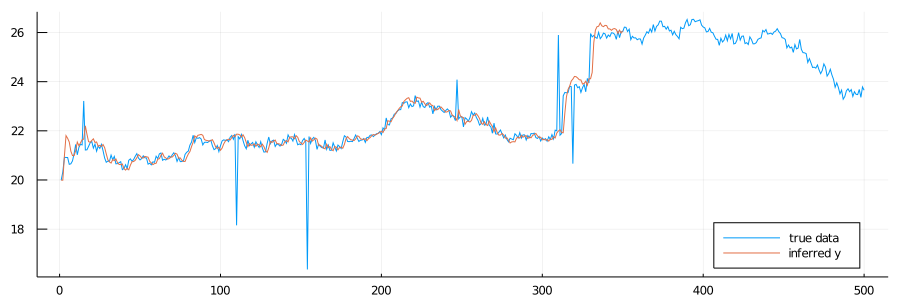

In [209]:
plot(y, label="true data", legend=:bottomright, size=(900,300))
plot!(y_best, label="inferred y")

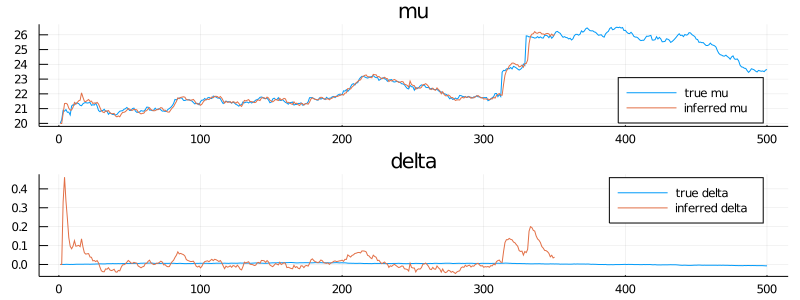

In [208]:
p1=plot(mu_true,label="true mu",title="mu",legend=:bottomright)
plot!([a[1] for a in alpha_best],label="inferred mu")

p2=plot(delta_true,label="true delta",title="delta")
plot!([a[2] for a in alpha_best],label="inferred delta")
p=plot(p1,p2,layout=(2,1),size=(800,300))

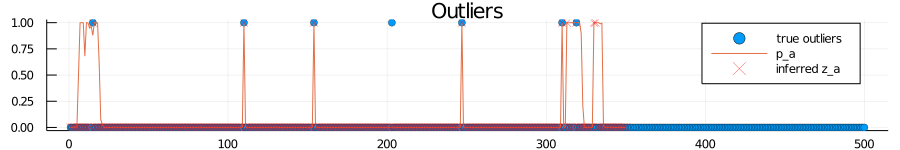

In [207]:
scatter(z_a_true, size=(900,150),label="true outliers",title="Outliers")
plot!(p_a_evolution[end],label="p_a")
scatter!(z_a_best,shape=[:x],color=:red, label="inferred z_a")

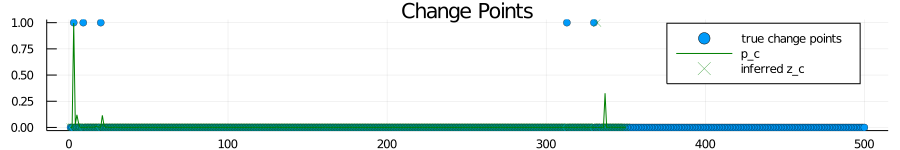

In [206]:
scatter(z_c_true, size=(900,150),label="true change points",title="Change Points")
plot!(p_c_evolution[end],label="p_c",color=:green)
scatter!(z_c_best,shape=[:x],color=:green, label="inferred z_c")

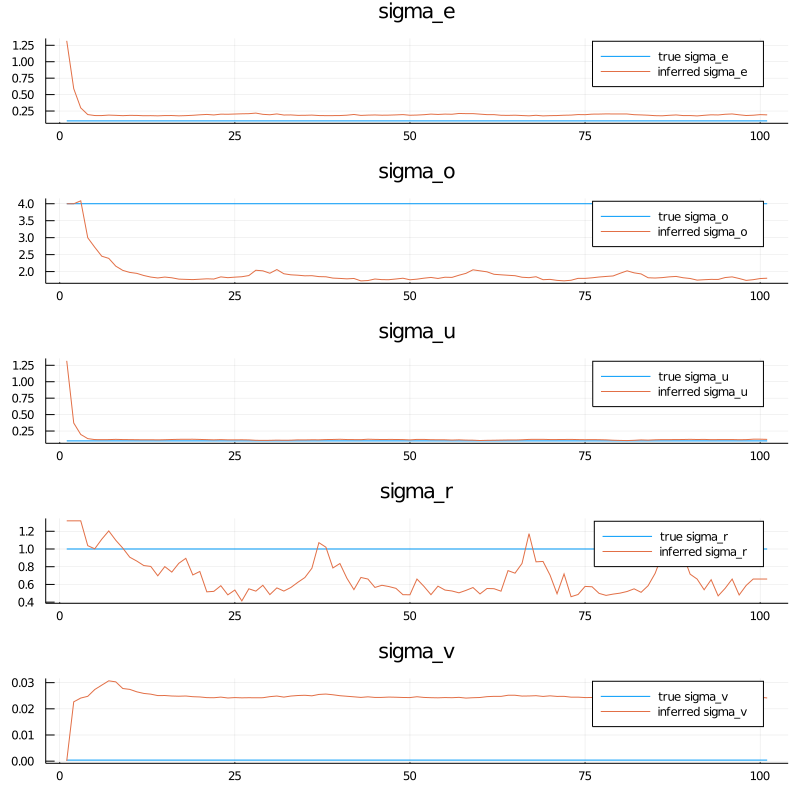

In [205]:
p1 = plot(sigma_true[1] * ones(length(sigma_evolution)),title="sigma_e",label="true sigma_e")
plot!([s[1] for s in sigma_evolution],label="inferred sigma_e")
p2 = plot(sigma_true[2] * ones(length(sigma_evolution)),title="sigma_o",label="true sigma_o")
plot!([s[2] for s in sigma_evolution],label="inferred sigma_o")
p3 = plot(sigma_true[3] * ones(length(sigma_evolution)),title="sigma_u",label="true sigma_u")
plot!([s[3] for s in sigma_evolution],label="inferred sigma_u")
p4 = plot(sigma_true[4] * ones(length(sigma_evolution)),title="sigma_r",label="true sigma_r")
plot!([s[4] for s in sigma_evolution],label="inferred sigma_r")
p5 = plot(sigma_true[5] * ones(length(sigma_evolution)),title="sigma_v",label="true sigma_v")
plot!([s[5] for s in sigma_evolution],label="inferred sigma_v")
plot(p1,p2,p3,p4,p5,layout=(5,1),size=(800,800))

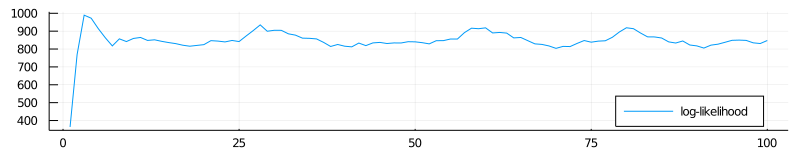

In [110]:
plot(log_L_list,size=(800,150),label="log-likelihood",legend=:bottomright)

## Forcasting
After the inference iterations, we can obtain the state variable $\pmb{\alpha}_t$ for all time points in the sequence, and also, we can obtain the posterior distributions of $\pmb{\sigma}$. Now, we have all the information we need to predict the future time series.

In this implementation, we can generate 100 future time series sequences $y_{future}$ by function [generative_procedure_future](#future). Then, we can combine them to derive the mean and 90% credible interval.

In [128]:
mu_0 = alpha_best[end][1]
delta_0 = alpha_best[end][2]

y_all = generative_procedure_future(mu_0, delta_0, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, L - L_train)
N = 100
for i in 1:(N-1)
    y_f = generative_procedure_future(mu_0, delta_0, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, L - L_train)
    y_all = hcat(y_all,y_f)
end

In [161]:
y_average = [mean(y_all[m,:]) for m in 1:length(y_all[:,1])]
for m in 1:length(y_all[:,1])
    y_all[m,:]=sort(y_all[m,:])
end

y_low = y_all[:,5]
y_high = y_all[:,95]

150-element Array{Float64,1}:
 26.458506138151947
 26.56553889224349
 26.72462799011428
 26.582775136125537
 26.790495705677984
 26.8662730789825
 26.991820185457208
 27.010022503163874
 27.15524083125234
 27.321537910563023
 27.545687747340192
 27.684632790821812
 27.852483995985043
  ⋮
 72.51504994055071
 72.86612543840863
 73.48505734264663
 73.48002012195921
 74.07441629916765
 74.2631577689475
 74.67932815393979
 75.10742876564473
 75.13784439736166
 75.35355362595627
 75.95723495438533
 76.24894180189769

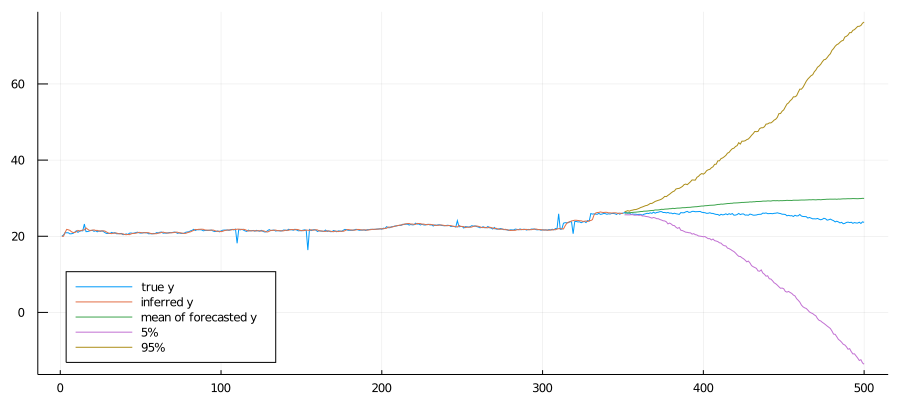

In [204]:
plot(y, label="true y",legend=:bottomleft,size=(900,400))
plot!(y_best, label="inferred y")
plot!(L_train+1:L, y_average, label="mean of forecasted y")
plot!(L_train+1:L, y_low, label="5%")
plot!(L_train+1:L, y_high, label="95%")

Reference: A.Y.Zhang, M.Lu, D.Kong, J.Yang, Bayesian Time Series Forecasting with Change Point and Anomaly Detection.

# <a id="3"></a>ARIMA Model
`In this section, we can see how to use the ARIMA model to forecast a time series.`

ARIMA(1,1,1) model is an autoregressive moving average model with first order differences. It is a general solution for forecasting the time series.

The ARIMA model has the similar functionality of filtering out the noises as the Kalman filter, thus, it can also be the nature choice of predicting the future state of our linear Gaussian model.

## Stationarity Test
It is obvious from the equation(1) that our linear Gaussian model contains a trend, which means it is not stationary. We can also check the stationary by Dickey-Fuller test.

We can first assume that this model is an AR(1) model, thus we have $y_t=\mu+\phi y_{t-1}+\epsilon_t$. Here, $\mu$ represents the constant mean of the model, regarding to the stationarity. $\phi$ is the coefficient of the lag.

Then we can derive the difference between two consecutive observations $y_t-y_{t-1}=\mu+(\phi-1)y_{t-1}+\epsilon_t$. The $(\phi-1)=0$ means that $\pmb{y}$ is not stationary.

We set the null hypothesis $H_0$ to $(\phi-1)=0$, and alternative hypothesis $H_1$ to $(\phi-1)<0$. And repeatedly difference observations, then we can obtain the test result. The *ADFTest* function in HypothesisTest package can help us do the test.

In [198]:
ADFTest(y_train, Symbol("constant"), 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.0603745

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.1582

Details:
    sample size in regression:          348
    number of lags:                     1
    ADF statistic:                      -2.34384
    Critical values at 1%, 5%, and 10%: [-3.44917 -2.86983 -2.57119]


We can see that the result of the test is "fail to reject h_0", so we can say the model does have a trend, it is not staionary.

It is a nature way to detrend the data by differencing. After that, we can obtain a stationary time series.

In [200]:
y_train_diff=diff(y_train)
ADFTest(y_train_diff, Symbol("constant"), 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -1.96315

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    sample size in regression:          347
    number of lags:                     1
    ADF statistic:                      -22.3185
    Critical values at 1%, 5%, and 10%: [-3.44923 -2.86986 -2.5712]


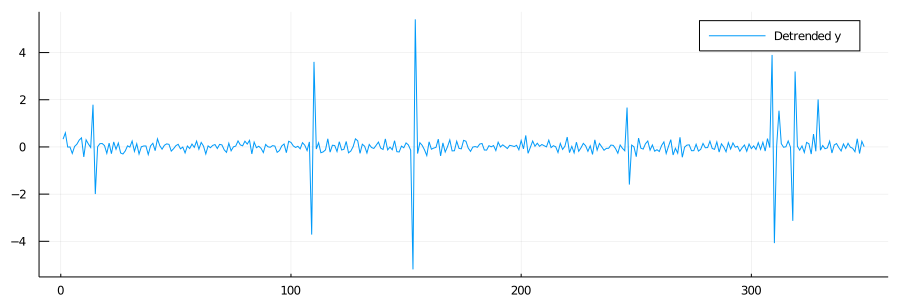

In [202]:
plot(y_train_diff, size=(900,300),label="Detrended y")

## Model Implementation 
Regarding to our linear model and its expressions, we can implement a ARIMA(1,1,0) model to infer the posterior distribution of parameters. The model can be expressed as follows:

In [177]:
@model ARIMA110(x) = begin
    T = length(x)
    
    # Prior
    μ ~ Uniform(-10, 10)
    ϕ ~ Uniform(-1, 1)
    σ ~ Truncated(Normal(0,100),0,Inf)
    
    # Likelihood
    for t in 3:T
        m = μ + x[t-1] + ϕ * (x[t-1] - x[t-2])
        x[t] ~ Normal(m, σ)
    end
end

ARIMA110 (generic function with 1 method)

In [178]:
chain_ARIMA110 = sample(ARIMA110(y_train_diff), NUTS(0.6),1000)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/xiaoxiao/.julia/packages/Turing/PyTy2/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/xiaoxiao/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (1000×15×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = μ, σ, ϕ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

           μ   -0.0036    0.0490     0.0015    0.0013   1492.5603    0.9990
           σ    0.8947    0.0339     0.0011    0.0008   1371.3689    0.9990
           ϕ   -0.6629    0.0401     0.0013    0.0008   1311.9500    0.9992

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           μ   -0.0938   -0.0353   -0.0023    0.0300    0.0931
           σ    0

In [181]:
μ=mean(chain_ARIMA110[:μ])
ϕ=mean(chain_ARIMA110[:ϕ])
σ=mean(chain_ARIMA110[:σ])

0.8947096625322463

## Forecasting
Finally, we can follow the way we used in previous model to generate 100 predicted sequences and combine them. The visualized forecasting results are showed as follows.

In [192]:
y_all_arima=[]
y_0_1=y_train_diff[end]
y_0_2=y_train_diff[end-1]
y_f_1=rand(Normal(μ + y_0_1 + ϕ * (y_0_1 - y_0_2),σ),1)[1]
y_f_2=rand(Normal(μ + y_f_1 + ϕ * (y_f_1 - y_0_1),σ),1)[1]
append!(y_all_arima,y_f_1)
append!(y_all_arima,y_f_2)
for t in 3:(L-L_train)
    y_t=rand(Normal(μ + y_f[t-1] + ϕ * (y_f[t-1] - y_f[t-2]),σ),1)[1]
    append!(y_all_arima,y_t)
end

for i in 1:(N-1)
    y_f=[]
    y_0_1=y_train_diff[end]
    y_0_2=y_train_diff[end-1]
    y_f_1=rand(Normal(μ + y_0_1 + ϕ * (y_0_1 - y_0_2),σ),1)[1]
    y_f_2=rand(Normal(μ + y_f_1 + ϕ * (y_f_1 - y_0_1),σ),1)[1]
    append!(y_f,y_f_1)
    append!(y_f,y_f_2)
    for t in 3:(L-L_train)
        y_t=rand(Normal(μ + y_f[t-1] + ϕ * (y_f[t-1] - y_f[t-2]),σ),1)[1]
        append!(y_f,y_t)
    end
    y_all_arima=hcat(y_all_arima,y_f)
end

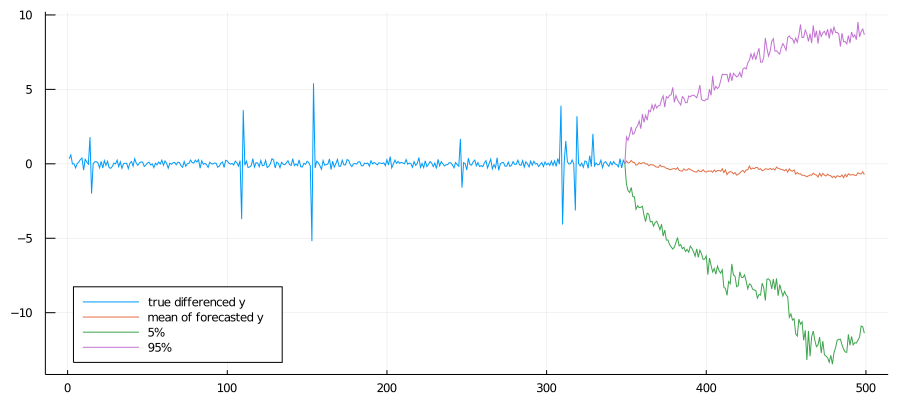

In [203]:
y_average_arima = [mean(y_all_arima[m,:]) for m in 1:length(y_all_arima[:,1])]
for m in 1:length(y_all_arima[:,1])
    y_all_arima[m,:]=sort(y_all_arima[m,:])
end

y_low_arima = y_all_arima[:,5]
y_high_arima = y_all_arima[:,95]

plot(y_train_diff, label="true differenced y",legend=:bottomleft,size=(900,400))
plot!(L_train-1:L-1, vcat(y_0_1,y_average_arima), label="mean of forecasted y")
plot!(L_train-1:L-1, vcat(y_0_1,y_low_arima), label="5%")
plot!(L_train-1:L-1, vcat(y_0_1,y_high_arima), label="95%")

Reference: https://towardsdatascience.com/arima-models-with-turing-jl-81dcf2a1094c